# 1번 군집

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score
from xgboost import XGBClassifier
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer

import warnings
warnings.filterwarnings("ignore")

In [11]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# 데이터 불러오기
df = pd.read_csv('./dataset/must_use_final.csv')
df["TIMESTAMP"] = pd.to_datetime(df["TIMESTAMP"])

# CLUSTER_1 == 1 데이터만 필터링
cluster1_df = df[df['CLUSTER_1'] == 1].copy()

# PORT_NAME 기준으로 라벨 인코딩
le = LabelEncoder()
cluster1_df['CLUSTER_2'] = le.fit_transform(cluster1_df['PORT_NAME'])

# 결과 확인
print("라벨링 완료된 CLUSTER_1 == 1 데이터")
# display(cluster1_df.head())
display(cluster1_df.sample(10))
print(f"CLUSTER_2 종류: {cluster1_df['CLUSTER_2'].unique().shape[0]}")

max_gap = pd.Timedelta(minutes=10)
hour = 14
time_based_data = []

for (vsl_id, port), group in df.groupby(["VSL_ID", "PORT_NAME"]):
    group = group.sort_values("TIMESTAMP")
    if group.empty:
        continue # 비어있으면 continue로 패스
    start_time = group["TIMESTAMP"].min() # 출발 시점
    target_time = start_time + pd.Timedelta(hours=hour)
    time_diff = (group["TIMESTAMP"] - target_time).abs()
    closest_idx = time_diff.idxmin() # 가장 작은 차이를 가진 인덱스 추출
    if time_diff[closest_idx] <= max_gap: # 10분보다 시간 차이 크면 무시
        closest_row = group.loc[closest_idx]
        time_based_data.append(closest_row) # 데이터 리스트에 저장
df_5h = pd.DataFrame(time_based_data).reset_index(drop=True)
df_5h

FileNotFoundError: [Errno 2] No such file or directory: './dataset/must_use_final.csv'

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    ConfusionMatrixDisplay, make_scorer, precision_score
)
from sklearn.utils import resample
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# ===== 1. 데이터 준비 (df_5h는 미리 준비되었다고 가정) =====
features = ["LAT", "LON", "COG", "HEADING"]
X_all = df_5h[features]
y_all = df_5h["PORT_NAME"].astype(str)

# ===== 2. 라벨 인코딩 =====
le = LabelEncoder()
y_encoded_all = le.fit_transform(y_all)

In [10]:
# ===== 3. 클래스 수가 2개 이상인 포트만 유지 =====
counts = pd.Series(y_encoded_all).value_counts()
valid_labels = counts[counts >= 2].index
mask = np.isin(y_encoded_all, valid_labels)
X_all = X_all[mask]
y_encoded_all = y_encoded_all[mask]

# ===== 4. 학습/테스트 분리 =====
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_encoded_all, test_size=0.2, stratify=y_encoded_all, random_state=42
)

# ===== 5. 오버샘플링 (train만) =====
train_data = pd.concat([
    X_train.reset_index(drop=True),
    pd.Series(y_train, name='label').reset_index(drop=True)
], axis=1)
train_data["PORT_NAME"] = le.inverse_transform(train_data["label"])

max_count = train_data['PORT_NAME'].value_counts().max()
oversampled_rows = []

for label in train_data['PORT_NAME'].unique():
    subset = train_data[train_data['PORT_NAME'] == label]
    if len(subset) < max_count:
        upsampled = resample(subset, replace=True, n_samples=max_count - len(subset), random_state=42)
        oversampled_rows.append(pd.concat([subset, upsampled]))
    else:
        oversampled_rows.append(subset)

df_train_oversampled = pd.concat(oversampled_rows).reset_index(drop=True)

# ===== 6. 재정의된 학습 데이터 =====
X_bal = df_train_oversampled[features]
y_bal = le.transform(df_train_oversampled["PORT_NAME"])

In [8]:
# ===== 7. 모델 탐색 (GridSearch) =====
param_grids = {
    "LogisticRegression": {
        'C': [0.01, 0.1, 1.0, 10.0],
        'solver': ['liblinear', 'lbfgs'],
        'penalty': ['l2'],
        'class_weight': [None, 'balanced']
    },
    "RandomForest": {
        'n_estimators': [100, 200],
        'max_depth': [None, 10],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_features': ['sqrt', 'log2'],
        "class_weight": ['balanced']
    }
}

lr = LogisticRegression()
rf = RandomForestClassifier()

lr_grid = GridSearchCV(lr, param_grids["LogisticRegression"], cv=5, scoring='accuracy', n_jobs=-1)
rf_grid = GridSearchCV(rf, param_grids["RandomForest"], cv=5, scoring='accuracy', n_jobs=-1)

lr_grid.fit(X_bal, y_bal)
rf_grid.fit(X_bal, y_bal)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'max_depth': [None, 10],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='accuracy')

In [12]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score, accuracy_score
import pandas as pd

# 개별 모델 정의 (간단한 하이퍼파라미터 적용)
lr = LogisticRegression(C=1.0, solver='liblinear', class_weight='balanced')
rf = RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced')
gb = GradientBoostingClassifier(n_estimators=100)
svc = SVC(C=1.0, kernel='rbf', probability=True, class_weight='balanced')

# 모델 조합 리스트 정의
combinations = [
    ('LR+RF', [('lr', lr), ('rf', rf)]),
    ('LR+RF+GB', [('lr', lr), ('rf', rf), ('gb', gb)]),
    ('LR+RF+SVC', [('lr', lr), ('rf', rf), ('svc', svc)]),
    ('LR+RF+GB+SVC', [('lr', lr), ('rf', rf), ('gb', gb), ('svc', svc)])
]

# 결과 저장용 리스트
results = []

# 각 조합에 대해 Soft Voting 성능 평가
for name, estimators in combinations:
    clf = VotingClassifier(estimators=estimators, voting='soft')
    
    acc = cross_val_score(clf, X_bal, y_bal, cv=5, scoring='accuracy').mean()
    f1  = cross_val_score(clf, X_bal, y_bal, cv=5, scoring='f1_macro').mean()
    
    results.append({'조합': name, 'Accuracy': round(acc, 4), 'Macro F1': round(f1, 4)})

# 결과 DataFrame으로 정리
import pandas as pd
result_df = pd.DataFrame(results).sort_values(by='Macro F1', ascending=False)
from IPython.display import display
display(result_df)


,조합,Accuracy,Macro F1
1,LR+RF+GB,0.9441,0.9424
3,LR+RF+GB+SVC,0.9441,0.9424
0,LR+RF,0.9254,0.9169
2,LR+RF+SVC,0.9193,0.9046



📌 Best Voting 조합: LR+RF+GB
📘 [Train Set]
Accuracy: 1.0
F1-score: 1.0

📙 [Test Set]
Accuracy: 0.6667
F1-score: 0.7696

📊 [교차검증 결과]
Train Accuracy : 1.0000
Test Accuracy  : 0.6667
Accuracy Gap   : 0.3333 ⚠️ 과적합 의심
CV Accuracy    : 0.9316 ± 0.0538
CV F1 Macro    : 0.9280
CV Precision   : 0.9468


In [16]:
# ===== 8. Voting Classifier (Soft) =====
voting_clf = VotingClassifier(
    estimators=[('lr', lr_grid.best_estimator_), ('rf', rf_grid.best_estimator_)],
    voting='soft'
)
voting_clf.fit(X_bal, y_bal)

# ===== 9. 평가 =====
y_train_pred = voting_clf.predict(X_bal)
y_test_pred = voting_clf.predict(X_test)

train_acc = accuracy_score(y_bal, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
train_f1 = f1_score(y_bal, y_train_pred, average='macro')
test_f1 = f1_score(y_test, y_test_pred, average='macro')

print("📘 [Train Set]")
print("Accuracy:", round(train_acc, 4))
print("F1-score:", round(train_f1, 4))

print("\n📙 [Test Set]")
print("Accuracy:", round(test_acc, 4))
print("F1-score:", round(test_f1, 4))

# ===== 10. 교차검증 =====
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_acc = cross_val_score(voting_clf, X_bal, y_bal, cv=skf, scoring='accuracy')
cv_f1 = cross_val_score(voting_clf, X_bal, y_bal, cv=skf, scoring=make_scorer(f1_score, average='macro'))
cv_prec = cross_val_score(voting_clf, X_bal, y_bal, cv=skf, scoring=make_scorer(precision_score, average='macro'))

print("\n📊 [교차검증 결과]")
print(f"Train Accuracy : {train_acc:.4f}")
print(f"Test Accuracy  : {test_acc:.4f}")
print(f"Accuracy Gap   : {train_acc - test_acc:.4f} {'⚠️ 과적합 의심' if train_acc - test_acc > 0.1 else '✅ 과적합 위험 없음'}")
print(f"CV Accuracy    : {cv_acc.mean():.4f} ± {cv_acc.std():.4f}")
print(f"CV F1 Macro    : {cv_f1.mean():.4f}")
print(f"CV Precision   : {cv_prec.mean():.4f}")


📘 [Train Set]
Accuracy: 1.0
F1-score: 1.0

📙 [Test Set]
Accuracy: 0.6667
F1-score: 0.7696

📊 [교차검증 결과]
Train Accuracy : 1.0000
Test Accuracy  : 0.6667
Accuracy Gap   : 0.3333 ⚠️ 과적합 의심
CV Accuracy    : 0.9193 ± 0.0506
CV F1 Macro    : 0.9125
CV Precision   : 0.9359


In [17]:
# ===== 최종 예측 라벨을 항구명으로 되돌리기 =====
y_test_pred_names = le.inverse_transform(y_test_pred)
y_test_true_names = le.inverse_transform(y_test)

# ===== 항구명 기반 Classification Report =====
print("\n📄 [Classification Report - PORT_NAME 기준]")
print(classification_report(y_test_true_names, y_test_pred_names))



📄 [Classification Report - PORT_NAME 기준]
              precision    recall  f1-score   support

       JPHIJ       1.00      1.00      1.00         1
       JPIMB       1.00      1.00      1.00         1
       KRINC       0.67      0.33      0.44         6
       KRKAN       1.00      0.67      0.80         3
       KRPTK       0.20      0.50      0.29         2
       KRUSN       1.00      1.00      1.00         2
       KRYOS       0.75      1.00      0.86         3

    accuracy                           0.67        18
   macro avg       0.80      0.79      0.77        18
weighted avg       0.76      0.67      0.68        18



In [62]:
for i in range(11):
    print(f"예측: {y_test_pred_names[i]} | 실제: {y_test_true_names[i]}")

예측: KRKAN | 실제: KRKAN
예측: KRYOS | 실제: KRYOS
예측: KRYOS | 실제: KRKAN
예측: KRYOS | 실제: KRYOS
예측: KRINC | 실제: KRPTK
예측: KRINC | 실제: KRINC
예측: KRINC | 실제: KRINC
예측: KRINC | 실제: KRINC
예측: KRUSN | 실제: KRUSN
예측: KRYOS | 실제: KRYOS
예측: KRYOS | 실제: KRKAN


In [64]:
import joblib
import os

# 모델 저장
joblib.dump(voting_clf, 'model/port_c1_14hours.joblib')

# 인코더 저장
joblib.dump(le, 'model/encoder_c1_14hours.joblib')

print("✅ 모델과 인코더가 각각 저장되었습니다.")

✅ 모델과 인코더가 각각 저장되었습니다.


# 4번 군집

In [56]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# 1. 데이터 불러오기
df = pd.read_csv("./dataset/cluster1_4.csv")

df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
df = df.sort_values(by=['VSL_ID', 'PORT_NAME', 'TIMESTAMP']).reset_index(drop=True)

# 결과 저장 리스트
rows_5h = []

# 30번째 시점 추출 (10분 단위 (1시간 - 6개) × 30 = 5시간)
for (vsl_id, port), group in df.groupby(['VSL_ID', 'PORT_NAME']):
    if len(group) >= 84:
        row_5h = group.iloc[83]  # 인덱스는 0부터 시작이므로 29번째가 30번째 행
        rows_5h.append(row_5h)

# 최종 데이터프레임
df_5h = pd.DataFrame(rows_5h).reset_index(drop=True)
print(df_5h.shape)
display(df_5h.head())
display(df_5h['PORT_NAME'].value_counts())

(32, 11)


,COUNTRY,PORT_NAME,VSL_ID,TIMESTAMP,COG,HEADING,LAT,LON,PORT_CD,CLUSTER_1,CLUSTER_2
0,CN,CNHUA,028690b9-6aba-3401-8d39-d602f2a30d82,2024-12-11 02:30:00,224.300000,224.000000,31.753972,126.405332,CNHUA,4,0
1,CN,CNHUA,091a653d-139a-33db-8f6d-2b5b389022d0,2024-09-02 16:30:00,220.200000,221.000000,32.448093,126.314127,CNHUA,4,0
2,HK,HKHKG,091a653d-139a-33db-8f6d-2b5b389022d0,2024-09-23 20:10:00,213.300000,216.000000,32.321093,126.596630,HKHKG,4,1
3,TW,TWKHH,0a0767cf-401a-3262-9c27-2f127d3ba8c1,2024-12-15 12:20:00,230.166667,229.666667,32.242647,126.078571,TWKHH,4,3
4,CN,CNHUA,0d13aad6-3c22-37e0-9106-76e8bb48e51e,2024-12-02 17:20:00,209.750000,210.000000,32.250801,126.769344,CNHUA,4,0


PORT_NAME
HKHKG    10
TWKEL    10
CNHUA     7
TWKHH     5
Name: count, dtype: int64

In [111]:
# ===== 1. 라이브러리 =====
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.utils import resample
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

# ===== 3. 라벨 인코딩 =====
features = ["LAT", "LON", "COG", "HEADING"]
X = df_5h[features]
y = df_5h["PORT_NAME"]

le = LabelEncoder()
y_encoded = le.fit_transform(y)   # 인코딩된 정답
df_5h["label"] = y_encoded  

## 4번 군집 - 오버샘플링

In [113]:
from sklearn.utils import resample

# 원본 클래스별 개수 출력
print("📊 [오버샘플링 전] 클래스별 샘플 수")
original_counts = df_5h['PORT_NAME'].value_counts()
display(original_counts)

# 기준이 될 최대 샘플 수의 1.5배로 설정
max_count = original_counts.max()
target_size = int(max_count * 1.5)

# 오버샘플링된 데이터 보관용 리스트
oversampled_rows = []

# 클래스별로 오버샘플링 수행
for label in df_5h['label'].unique():
    subset = df_5h[df_5h['label'] == label]
    if len(subset) < target_size:
        upsampled = resample(subset,
                             replace=True,
                             n_samples=target_size,
                             random_state=42)
        oversampled_rows.append(upsampled)
    else:
        oversampled_rows.append(subset)

# 오버샘플링된 데이터프레임 생성
df_5h_oversampled = pd.concat(oversampled_rows).reset_index(drop=True)

# ===== 오버샘플링 후 클래스별 개수 확인 =====
print("\n📊 [오버샘플링 후] 클래스별 샘플 수")
after_counts = df_5h_oversampled['PORT_NAME'].value_counts()
display(after_counts)


📊 [오버샘플링 전] 클래스별 샘플 수


PORT_NAME
HKHKG    10
TWKEL    10
CNHUA     7
TWKHH     5
Name: count, dtype: int64


📊 [오버샘플링 후] 클래스별 샘플 수


PORT_NAME
CNHUA    15
HKHKG    15
TWKHH    15
TWKEL    15
Name: count, dtype: int64

In [121]:
# ===== ✅ 오버샘플링 후 X, y 재정의 =====
X = df_5h_oversampled[features]
y = df_5h_oversampled["PORT_NAME"]
y_encoded = le.fit_transform(y)  # 다시 인코딩 수행

# ===== ✅ 오버샘플링 후 데이터로 학습/테스트 분할 =====
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

np.save("datasets/X_train_c4_14hours.npy", X_train)
np.save("datasets/X_test_c4_14hours.npy", X_test)
np.save("datasets/y_train_c4_14hours.npy", y_train)
np.save("datasets/y_test_c4_14hours.npy", y_test)

# ===== 1. 제약 강화된 XGBoost 하이퍼파라미터 튜닝 =====
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42,
    reg_alpha=0.1,
    reg_lambda=1.0
)
xgb_grid = GridSearchCV(xgb_model, xgb_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
xgb_grid.fit(X_train, y_train)
best_xgb = xgb_grid.best_estimator_
print("✅ Best XGBoost:", xgb_grid.best_params_)

# ===== 2. LogisticRegression 하이퍼파라미터 튜닝 =====
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=500)
lr_param_grid = {
    'C': [0.01, 0.1, 1.0, 10.0],
    'solver': ['liblinear', 'lbfgs'],
    'penalty': ['l2'],
    'class_weight': [None, 'balanced']
}
lr_grid = GridSearchCV(lr_model, lr_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
lr_grid.fit(X_train, y_train)
best_lr = lr_grid.best_estimator_
print("✅ Best LogisticRegression:", lr_grid.best_params_)

# ===== 3. 소프트 보팅 앙상블 (XGB + LR) =====
voting_clf = VotingClassifier(
    estimators=[('xgb', xgb), ('lr', lr_pipeline)],
    voting='soft',
    weights=[1, 2]  # 일반화 좋은 Logistic 비중 ↑
)
voting_clf.fit(X_train, y_train)

✅ Best XGBoost: {'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 150, 'subsample': 0.8}
✅ Best LogisticRegression: {'C': 0.1, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='mlogloss',
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_c...
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None, ...)),
                             ('lr',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('logisticregression',
                                               LogisticRegression(class_weight='balanced',
                                                                  max_iter=500,
                                                                  random_state=42,
                                                                  solver='liblinear'))]))],
                 voting='soft', weights=[1, 2])


📊 [앙상블 성능 평가 및 과적합 진단]
Train Accuracy           : 1.0000
Test Accuracy            : 0.9167
Accuracy Gap             : 0.0833 ✅ 과적합 위험 없음
Train F1-score (macro)   : 1.0000
Test F1-score (macro)    : 0.9143
CV Accuracy Mean         : 0.9333 ± 0.0624
CV F1-score Mean         : 0.9282
CV Precision Mean        : 0.9550

📄 [Classification Report]
              precision    recall  f1-score   support

       CNHUA       1.00      1.00      1.00         3
       HKHKG       1.00      0.67      0.80         3
       TWKEL       1.00      1.00      1.00         3
       TWKHH       0.75      1.00      0.86         3

    accuracy                           0.92        12
   macro avg       0.94      0.92      0.91        12
weighted avg       0.94      0.92      0.91        12



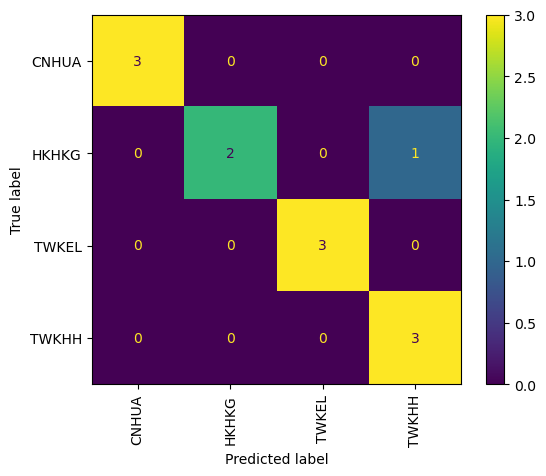

In [122]:
# ===== 4. 예측 및 평가 =====
y_train_pred = voting_clf.predict(X_train)
y_test_pred = voting_clf.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
train_f1 = f1_score(y_train, y_train_pred, average='macro')
test_f1 = f1_score(y_test, y_test_pred, average='macro')
gap = train_acc - test_acc

# ===== 5. 교차검증 =====
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_acc = cross_val_score(voting_clf, X, y_encoded, cv=skf, scoring='accuracy')
cv_f1 = cross_val_score(voting_clf, X, y_encoded, cv=skf, scoring=make_scorer(f1_score, average='macro'))
cv_prec = cross_val_score(voting_clf, X, y_encoded, cv=skf, scoring=make_scorer(precision_score, average='macro'))

# ===== 6. 결과 출력 =====
print("\n📊 [앙상블 성능 평가 및 과적합 진단]")
print(f"Train Accuracy           : {train_acc:.4f}")
print(f"Test Accuracy            : {test_acc:.4f}")
print(f"Accuracy Gap             : {gap:.4f} {'⚠️ 과적합 의심' if gap > 0.1 else '✅ 과적합 위험 없음'}")
print(f"Train F1-score (macro)   : {train_f1:.4f}")
print(f"Test F1-score (macro)    : {test_f1:.4f}")
print(f"CV Accuracy Mean         : {cv_acc.mean():.4f} ± {cv_acc.std():.4f}")
print(f"CV F1-score Mean         : {cv_f1.mean():.4f}")
print(f"CV Precision Mean        : {cv_prec.mean():.4f}")

print("\n📄 [Classification Report]")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))

ConfusionMatrixDisplay.from_estimator(voting_clf, X_test, y_test, display_labels=le.classes_, xticks_rotation=90)

In [118]:
# 클래스 목록과 숫자 라벨의 매핑 출력
label_mapping = dict(zip(le.transform(le.classes_), le.classes_))
print("📍 라벨 인코딩 매핑표:")
for k, v in label_mapping.items():
    print(f"{k} → {v}")

📍 라벨 인코딩 매핑표:
0 → CNHUA
1 → HKHKG
2 → TWKEL
3 → TWKHH


In [125]:
import joblib
import os

# 모델 저장
joblib.dump(voting_clf, 'model/port_c4_14hours.joblib.joblib')

# 인코더 저장
joblib.dump(le, 'model/encoder_c4_14hours.joblib')

print("✅ 모델과 인코더가 각각 저장되었습니다.")

✅ 모델과 인코더가 각각 저장되었습니다.
